# SFR/Mdust vs. LX

This notebook explores the connection between SFR/Mdust and X-ray luminosity to see if AGN host galaxies are particularly gas rich given their SFR and if the luminosity of the AGN has any effect.

In [1]:
# Standard module imports
import numpy as np
import scipy.stats as stats
import pandas as pd
pd.options.display.max_rows = 999
import sys
%matplotlib inline

# Useful directories
gh_dir = '/Users/ttshimiz/Github/'
sed_fit_dir = gh_dir + 'bat-agn-sed-fitting/'
casey_dir = sed_fit_dir + 'analysis/casey_bayes_results/'
data_dir = gh_dir + 'bat-data/'

sys.path.append(gh_dir+'asurv/')

import asurv

In [3]:
# Setup the figures
style='paper'
execfile('/Users/ttshimiz/Dropbox/Research/figure_setup.py')

In [4]:
# Upload the fitting results for the C12 model
bat_casey = pd.read_csv('../data/bat-agn-c12-params.csv', index_col=0)
herschel_data = pd.read_csv(data_dir+'bat_herschel.csv', index_col=0,
                            na_values=0)
plw_flag = herschel_data['PLW_flag']
herschel_data['PLW'][plw_flag == 'AD'] = np.nan
bat_casey['PLW'] = herschel_data['PLW']
# Remove 'bad' sources
bad_sources = np.array(['PICTORA', '3C111.0', '3C120',
                        '2MASXJ23272195+1524375', 'PKS2331-240',
                        'HB890241+622', 'Mrk3'])
bat_casey = bat_casey.drop(bad_sources)
#bat_casey.loc['UGC06728', 'lir_sf'] += 2.0
#bat_casey.loc['UGC06728', 'mdust'] += 2.0

# Upload the info for the BAT AGN (i.e. AGN type, luminosity distance, redshift, etc)
bat_info = pd.read_csv(data_dir+'bat_info.csv', index_col=0)
bat_casey['Dist'] = bat_info['Dist_[Mpc]']
#bat_info.loc['UGC06728', 'Dist_[Mpc]'] = 292.0

# We need to calculate stellar masses for the BAT AGN using the method in Zibetti et al 2009 since this method was used
# for both the KINGFISH and HRS galaxies. I use the AGN subtracted SDSS photometry from Koss et al 2011 and the g-i color
# relation for the stellar masses.
bat_koss = pd.read_csv(data_dir+'bat_koss11.csv', index_col=0)
bat_koss.loc[bat_koss['griz_cont']=='Y', 'SDSS_i_Koss'] = np.nan
bi = 1.8e-10
bat_koss['SDSS_i_flux'] = 3631.*(2*bi*np.sinh(-np.log(10)*bat_koss['SDSS_i_Koss']/2.5 - np.log(bi)))
bat_koss['SDSS_Li'] = 4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*(3.0e10/0.7480e-4)*bat_koss['SDSS_i_flux']*10**(-23)
bat_casey['Mstar'] = (-0.963 + 1.032*(bat_koss['SDSS_g_Koss'] - bat_koss['SDSS_i_Koss']) +
                     np.log10(bat_koss['SDSS_Li']/3.846e33))

/Users/ttshimiz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# Upload the HRS fits
hrs_casey = pd.read_csv(casey_dir+'hrs_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_hrs.csv', index_col=0)
hrs_casey_undetected = pd.read_csv(casey_dir+'hrs_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_undetected_hrs.csv', index_col=0)
hrs_all = pd.concat([hrs_casey, hrs_casey_undetected])
hrs_all.loc[hrs_casey_undetected.index, 'Flag'] = -1
hrs_all.loc[hrs_casey.index, 'Flag'] = 0
# Remove the BAT AGN in the HRS
hrs_all = hrs_all.drop([4,144,288,296])

# Upload the HRS info
hrs_info = pd.read_table(gh_dir+'hrs-data/hrs_photometry.txt', delimiter='\t', index_col=0, na_values=-99.99)
hrs_info = hrs_info.drop([4,144,288,296])

# HRS gas-rich galaxies
hrs_gas_rich = np.array([np.loadtxt(gh_dir+'hrs-data/hrs_gas_rich_numbers.txt')], dtype = int)[0]

hrs_all['Mstar'] = hrs_info['logMstart']
hrs_all['Dist'] = hrs_info['Dist_Mpc']
hrs_all['S500'] = hrs_info['S500']

# Upload the IDs for our mass selected HRS sample
mass_select = pd.read_csv('mass_selected_hrs_ids.csv', index_col=0)
hrs_mass_select = pd.DataFrame(index=mass_select.index, columns=hrs_all.columns)

for n in mass_select.index:
    
    hrs_mass_select.loc[n] = hrs_all.loc[np.int(mass_select.loc[n, 'HRS ID'])]
    hrs_mass_select.loc[n, 'HRS ID'] = np.int(mass_select.loc[n, 'HRS ID'])

In [6]:
# Calculate SFR for all three samples
bat_casey['SFR'] = bat_casey['lir_sf'] + np.log10(3.846e33) - np.log10(2.57e43)
hrs_casey['SFR'] = hrs_casey['lir_total'] + np.log10(3.846e33) - np.log10(2.57e43)
hrs_mass_select['SFR'] = hrs_mass_select['lir_total'] + np.log10(3.846e33) - np.log10(2.57e43)
hrs_casey_undetected['SFR'] = hrs_casey_undetected['lir_total'] + np.log10(3.846e33) - np.log10(2.57e43)

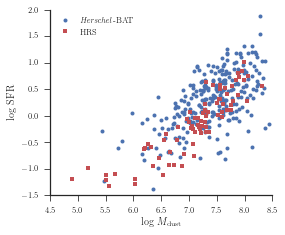

In [73]:
fig = plt.figure(figsize=(1.2*columnwidth, columnwidth))
ax = fig.add_subplot(111)
plt.plot(bat_casey['mdust'][bat_casey['mdust_flag'] != -1], bat_casey['SFR'][bat_casey['mdust_flag']!=-1], 'bo', ms=4)
plt.plot(hrs_mass_select['mdust'][hrs_mass_select['Flag'] != -1], hrs_mass_select['SFR'][hrs_mass_select['Flag']!=-1],
         'rs', ms=4)
sn.despine()

ax.set_xlabel(r'$\log$ $M_{\rm dust}$')
ax.set_ylabel(r'$\log$ SFR')
ax.legend([r'\textit{Herschel}-BAT', 'HRS' ], loc='upper left')
fig.savefig('../figures/sfr_vs_mdust.pdf', bbox_inches='tight')

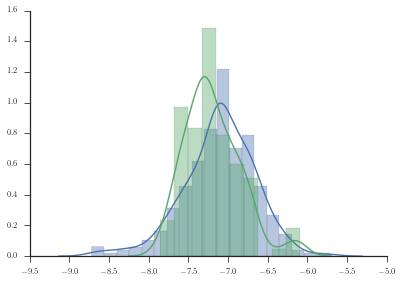

In [25]:
sn.distplot(bat_casey['SFR']-bat_casey['mdust'])
sn.distplot(hrs_mass_select['SFR']-hrs_mass_select['mdust'])
sn.despine()

Hmmm this is intriguing. These two plots seem to indicate that for a given dust mass, the AGN actually have a higher SFR. If we assume dust mass scales with gas mass this means that the SFE = SFR/Mgas is higher for AGN. 

Need to check to make sure this isn't an artifact of the SED decomposition. If it is then we should see a clear trend of SFR/Mdust with agn_frac.

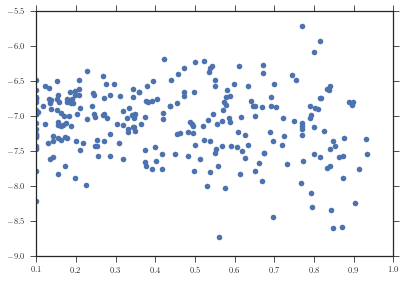

In [36]:
plt.plot(bat_casey['agn_frac'][bat_casey['mdust_flag'] != -1],
        bat_casey['SFR'][bat_casey['mdust_flag'] != -1] - bat_casey['mdust'][bat_casey['mdust_flag'] != -1],
        'bo')

No it doesn't seem to be related to the SED decomposition. It is likely that this is a real effect.

I wonder if it is related to quenching. To see if this might be the case, I'm going to plot SFR vs. Mstar with the points colored with SFR/Mdust.

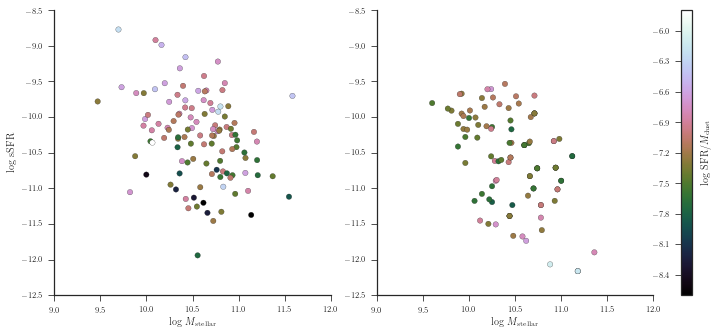

In [72]:
fig = plt.figure(figsize=(12.8, 4.4))

ax1 = fig.add_axes([0.1, 0.1, 0.3, 0.9])
sc1 = ax1.scatter(bat_casey['Mstar'][bat_casey['mdust_flag'] != -1], bat_casey['SFR'][bat_casey['mdust_flag'] != -1]-bat_casey['Mstar'][bat_casey['mdust_flag'] != -1],
        c=bat_casey['SFR'][bat_casey['mdust_flag'] != -1] - bat_casey['mdust'][bat_casey['mdust_flag'] != -1],
        s=30, cmap='cubehelix', vmin=-8.6, vmax=-5.8)
ax1.set_ylabel(r'$\log$ sSFR')
ax1.set_xlabel(r'$\log\,M_{\rm stellar}$')

ax2 = fig.add_axes([0.45, 0.1, 0.3, 0.9])
sc2 = ax2.scatter(hrs_mass_select['Mstar'][hrs_mass_select['Flag'] != -1], hrs_mass_select['SFR'][hrs_mass_select['Flag'] != -1]-hrs_mass_select['Mstar'][hrs_mass_select['Flag'] != -1],
        c=hrs_mass_select['SFR'][hrs_mass_select['Flag'] != -1] - hrs_mass_select['mdust'][hrs_mass_select['Flag'] != -1],
        s=30, cmap='cubehelix', vmin=-8.6, vmax=-5.8)
ax2.set_xlabel(r'$\log\,M_{\rm stellar}$')
cax = fig.add_axes([0.78, 0.1, 0.012, 0.9])
cb = fig.colorbar(sc2, cax=cax)
cb.set_label(r'$\log$ SFR/$M_{\rm dust}$', labelpad=10)
ax2.set_xlim(9.0, 12.0)
ax2.set_ylim(-12.5, -8.5)

sn.despine()


4.4


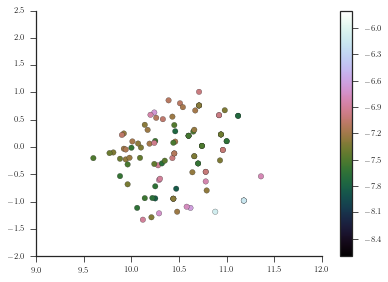

In [48]:
plt.scatter(hrs_mass_select['Mstar'][hrs_mass_select['Flag'] != -1], hrs_mass_select['SFR'][hrs_mass_select['Flag'] != -1],
        c=hrs_mass_select['SFR'][hrs_mass_select['Flag'] != -1] - hrs_mass_select['mdust'][hrs_mass_select['Flag'] != -1],
        s=30, cmap='cubehelix', vmin=-8.6, vmax=-5.8)
sn.despine()
plt.colorbar()
plt.xlim(9.0, 12.0)
plt.ylim(-2.0, 2.5)
fig = plt.gcf()
print fig.get_figheight()